In [1]:
# download packages
!pip install -U spaCy
!python -m spacy download nl
!python -m spacy download nl_core_news_sm
!pip install wordcloud matplotlib

Requirement already up-to-date: spaCy in c:\users\martinewester\anaconda3\lib\site-packages (2.2.3)
[+] Download and installation successful
You can now load the model via spacy.load('nl_core_news_sm')
[x] Couldn't link model to 'nl'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\MartineWester\Anaconda3\lib\site-packages\nl_core_news_sm -->
C:\Users\MartineWester\Anaconda3\lib\site-packages\spacy\data\nl
[!] Download successful but linking failed
Creating a shortcut link for 'nl' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('nl_core_news_sm')


You do not have sufficient privilege to perform this operation.


[+] Download and installation successful
You can now load the model via spacy.load('nl_core_news_sm')


In [2]:
# import packages
import json
import requests as r
import itertools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from spacy import displacy
from collections import Counter
from gensim.models import Word2Vec    
from sklearn.decomposition import 
from gensim import models
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np
%matplotlib notebook

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MartineWester\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MartineWester\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# functie die een wordcloud genereert op basis van text
def show_wordcloud(text):
    # Creeer wordcloud
    wordcloud = WordCloud().generate(text)

    # genereer plaatje van de wordcloud:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [51]:
# geef hier aan van welk onderwerp je informatie wil. 
subject = 'asbest'

In [52]:
#nieuws api
# run deze cel wanneer je het nieuws mbt het onderwerp op wil halen
url = "https://opendata.rijksoverheid.nl/v1/sources/rijksoverheid/infotypes/news?subject="+subject.replace(" ", "+")+"&output=json"
response = r.get(url)
json = response.json()

In [22]:
# kamerstukken api
# run deze cel wanneer je kamerstukken mbt het onderwerp op wil halen
url = "https://opendata.rijksoverheid.nl/v1/sources/rijksoverheid/documents?subject="+subject.replace(" ", "+")+"&output=json"
response = r.get(url)
json = response.json()

In [23]:
 # Hier worden alle introductie texten van de kamervragen
 #  die betrekking hebben tot het onderwerp opgeslagen in de variabele 'text'.
text = []
for i in range(0,len(json)):
    intro = json[i]['introduction']
    text.append(intro)
#     print(intro)

text = re.sub("[^a-zA-Z]"," ",str(text))
text = text.lower()

In [53]:
# Hier worden alle stopwoorden uit de text gehaald en vervolgens opgeslagen als 'filtered_text'. 
# stop_words = set(stopwords.words('dutch')) 
stopwords = nltk.corpus.stopwords.words('dutch')
nieuwe_stopwoorden = ['beantwoordt', 'vragen','beantwoordt vragen','vragen van', 'kamerleden','het kamerlid', 'p', 'beiden', 'informeert', 'tweede kamer', 'tweede', 'kamer']
stopword = stopwords + nieuwe_stopwoorden
word_tokens = word_tokenize(text) 
filtered_text = [] 

for w in word_tokens: 
    if w not in stopword: 
        filtered_text.append(w) 

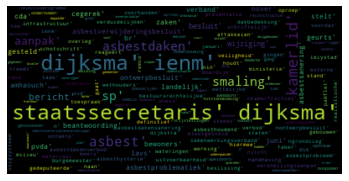

In [54]:
# print de wordcloud van filtered_text. 
show_wordcloud(str(filtered_text))

In [55]:
#laadt spacy 
nlp = spacy.load('nl_core_news_sm')
doc = nlp(str(filtered_text))
displacy.render(doc, style='ent', jupyter=True)

In [18]:
doc = nlp(str(text))
displacy.render(doc, style='ent', jupyter=True)

In [56]:
# welke entiteiten zijn er, en hoeveel 
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'ORG': 7,
         'GPE': 12,
         'NORP': 27,
         'PERSON': 9,
         'DATE': 2,
         'CARDINAL': 1})

In [68]:
# nu wil ik de woorden van de drie meestvoorkomende entiteiten in een list hebben. 
items = [x.text for x in doc.ents]
most_common = Counter(items).most_common(3)
print(most_common)
top_3 = [x for x,_ in most_common]
print(top_3)

[('dijksma', 17), ('sp', 5), ('asbestdaken', 3), ('nover', 2)]
['dijksma', 'sp', 'asbestdaken', 'nover']


In [69]:
# inladen van model
model = models.KeyedVectors.load_word2vec_format(
    '39\model.bin', binary=True)

In [64]:
#hier geef ik de woorden van mijn top3 entiteiten
keys = top_3

# lege lists die straks gevuld worden
embedding_clusters = []
word_clusters = []

# per woord, zoek 10 meest soortgelijke woorden op uit de wordembeddings, en sla deze op in de lege lists
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [65]:
# cluster deze wordembeddings op mbv tsne
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


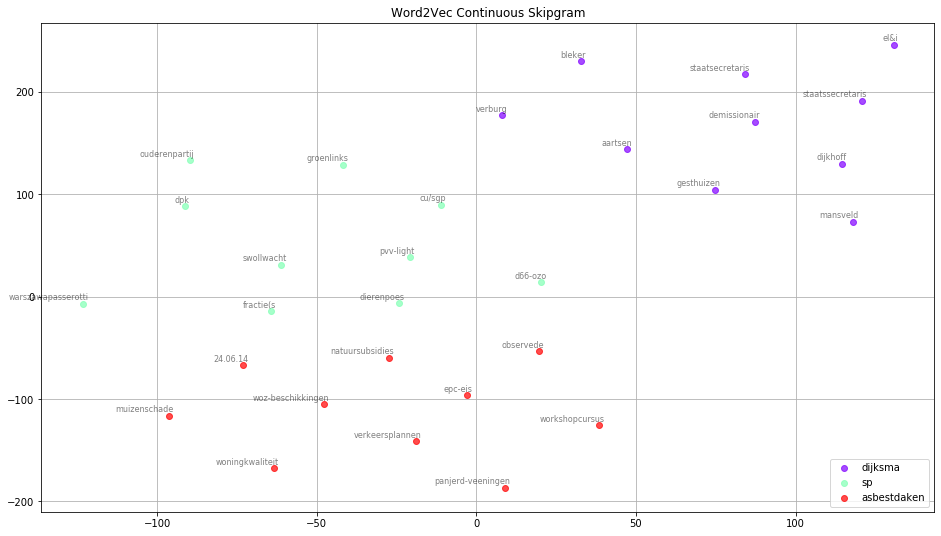

In [66]:
# plot de clusters
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Word2Vec Continuous Skipgram', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')